---
# <CENTER><font color="indigo">Generative Models: Autoencoders (AE)</font><br><small><b>SPARSE AUTOENCODERS</b></small>
---
<font color="olive">Prepared by **NICHOLAS DOMINIC**
<br>Guided from *Aurélien Géron*'s **Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow** (2nd ed., by O’Reilly Media, Inc.)
<br>Powered by Interactive Python **Jupyter Notebook** (.ipynb), developed with **Python 3.7**

> **BRIEF INTRODUCTION**<br>
Generative model is capable of randomly generating new data that looks *very similar* to the training data. Simply put, the output is the input itself (same size). Therefore in this case, the output also called as **reconstruction**. Two types of generative model are: **Autoencoders (AE)** and **Generative Adversarial Networks (GAN)**.

In [1]:
import numpy as np
from pandas import DataFrame as df
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [2]:
np.__version__, tf.__version__, keras.__version__

('1.18.2', '2.2.0', '2.3.0-tf')

## Fashion-MNIST Dataset Loading, Normalization, and Split

In [3]:
# Load the dataset from Keras
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

# Normalize by dividing them by 255 (maximum number of 1-bit pixels)
x_train = x_train.astype(np.float32) / 255
x_test = x_test.astype(np.float32) / 255

# Get validation data from train data
x_train, x_val = x_train[:-5000], x_train[-5000:]
y_train, y_val = y_train[:-5000], y_train[-5000:]

# Show the shape of each
print("Image Dimension: {}".format(x_train.shape[1:]))
print("x_train: {} y_train: {}".format(x_train.shape, y_train.shape))
print("x_val: {} y_val: {}".format(x_val.shape, y_val.shape))
print("x_test: {} y_test: {}".format(x_test.shape, y_test.shape))

Image Dimension: (28, 28)
x_train: (55000, 28, 28) y_train: (55000,)
x_val: (5000, 28, 28) y_val: (5000,)
x_test: (10000, 28, 28) y_test: (10000,)


## User-defined Functions and Class

In [4]:
# Custom metrics (how to build it, see on https://keras.io/api/metrics/#creating-custom-metrics)
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [5]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

In [6]:
def show_reconstructions(model, images=x_val, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

In [7]:
kl_divergence = keras.losses.kullback_leibler_divergence
class KLDivergenceRegularizer(keras.regularizers.Regularizer):
    def __init__(self, weight, target=.1):
        self.weight = weight
        self.target = target
    def __call__(self, inputs):
        mean_activities = keras.backend.mean(inputs, axis=0)
        return self.weight * (
            kl_divergence(self.target, mean_activities) +
            kl_divergence(1. - self.target, 1. - mean_activities))

* **Step 1: BUILD**

In [8]:
# Build the ENCODER
encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid", activity_regularizer=KLDivergenceRegularizer(weight=.05, target=.1))
], name="Encoder")
encoder.summary()

# Build the DECODER
decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
], name="Decoder")
decoder.summary()

# Join both to generate SPARSE AUTOENCODER
sparse_L1_ae = keras.models.Sequential([encoder, decoder], name="Sparse_Autoencoder")
sparse_L1_ae.summary()

Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dense_1 (Dense)              (None, 300)               30300     
Total params: 108,800
Trainable params: 108,800
Non-trainable params: 0
_________________________________________________________________
Model: "Decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_3 (Dense)              (None, 784)               79184     
____________________________________

* **Step 2: COMPILE**

In [9]:
sparse_L1_ae.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.SGD(lr=.5),
    metrics=[rounded_accuracy]
)

* **Step 3: FIT / TRAIN**

In [10]:
sparse_L1_ae_history = sparse_L1_ae.fit(x_train, x_train, epochs=20, batch_size=1, validation_data=(x_val, x_val))

Epoch 1/20
55000/55000 [==============================] - 227s 4ms/step - loss: 0.4520 - rounded_accuracy: 0.7927 - val_loss: 0.4135 - val_rounded_accuracy: 0.8342
Epoch 2/20
55000/55000 [==============================] - 204s 4ms/step - loss: 0.4100 - rounded_accuracy: 0.8503 - val_loss: 0.4075 - val_rounded_accuracy: 0.8621
Epoch 3/20
55000/55000 [==============================] - 206s 4ms/step - loss: 0.4074 - rounded_accuracy: 0.8613 - val_loss: 0.3819 - val_rounded_accuracy: 0.8808
Epoch 4/20
55000/55000 [==============================] - 192s 3ms/step - loss: 0.4187 - rounded_accuracy: 0.8631 - val_loss: 0.3761 - val_rounded_accuracy: 0.8853
Epoch 5/20
55000/55000 [==============================] - 188s 3ms/step - loss: 0.4278 - rounded_accuracy: 0.8635 - val_loss: 0.4183 - val_rounded_accuracy: 0.8732
Epoch 6/20
55000/55000 [==============================] - 165s 3ms/step - loss: 0.4306 - rounded_accuracy: 0.8645 - val_loss: 0.4502 - val_rounded_accuracy: 0.8389
Epoch 7/20
55000

Text(0, 0.5, 'Scores')

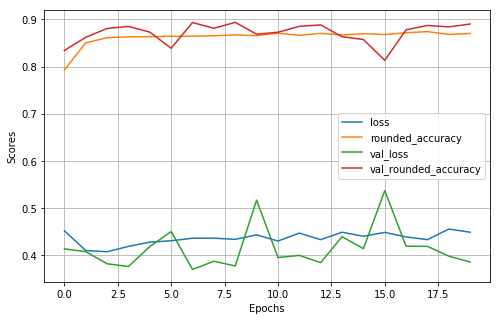

In [11]:
df(sparse_L1_ae_history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.xlabel("Epochs")
plt.ylabel("Scores")

* **Step 4: EVALUATE**

In [12]:
sparse_L1_ae.evaluate(x_test, x_test, batch_size=1)

10000/10000 [==============================] - 26s 3ms/step - loss: 0.3852 - rounded_accuracy: 0.8894


[0.38524648547172546, 0.8893837928771973]

* **Step 5: PREDICTION**
<br> The first rows denote real images, while the second reconstructed images from Sparse AE.

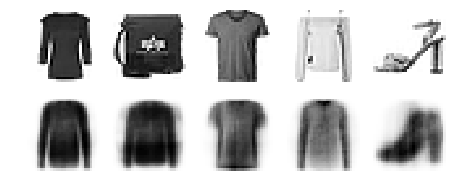

In [13]:
show_reconstructions(sparse_L1_ae)

In [16]:
# Can't save the model due to KLDivergenceRegularizer() as custom subclass Keras model; thus, .save_weights() instead
# See for details in https://stackoverflow.com/questions/51806852/cant-save-custom-subclassed-model
sparse_L1_ae.save_weights("model/sparseAE_weights/sparse_L1_ae_weights.ckpt")